In [1]:
# Importing necessary libraries and modules

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd
import numpy as np
from scipy.spatial import distance

import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import (
    resnet34,
    ResNet34_Weights,
    resnet18,
    ResNet18_Weights,
    vgg11,
    VGG11_Weights,
)

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tqdm.auto import tqdm
import seaborn as sb

from copy import deepcopy

# Set seaborn theme
sb.set_theme()

In [2]:
# Check if CUDA is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Load Data

In [3]:
# Define a series of transformations to apply to an image.

transform = transforms.Compose(
    [
        transforms.Resize(size=256),  # Resize the image to 256x256 pixels.
        transforms.CenterCrop(
            size=224
        ),  # Crop the center of the image to 224x224 pixels.
        transforms.ToTensor(),  # Convert the image to a tensor.
        transforms.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        ),  # Normalize the image with mean and standard deviation.
    ]
)

In [5]:
# Load the training data
train_data = datasets.CIFAR10("data", train=True, download=True, transform=transform)

# Load the test data
test_data = datasets.CIFAR10("data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Split the training data into training and validation subsets
train_subset, val_subset = torch.utils.data.random_split(
    train_data, [0.85, 0.15], generator=torch.Generator().manual_seed(1)
)

In [7]:
class ResNet34:
    def __init__(self):
        # Load the ResNet34 model with default weights
        self.resnet34 = resnet34(weights=ResNet34_Weights.DEFAULT)
        modules = list(self.resnet34.children())[:-1]

        # Create a new model with all the layers except the last one
        self.resnet34 = torch.nn.Sequential(*modules)

        self.resnet34.eval()  # Set the model to evaluation mode

        self.resnet34 = self.resnet34.to(device)

    def __repr__(self):
        return "ResNet34"

    def get_features(self, images):
        with torch.no_grad():
            # Get the features from the features extractor model
            features = self.resnet34(images)
        return features

    def get_size(self):
        with torch.no_grad():
            features = torch.flatten(
                self.resnet34(torch.zeros(1, 3, 224, 224).to(device)), start_dim=1
            )
        # Return the size of the features
        return features.shape

In [8]:
class ResNet18:
    def __init__(self):
        # Load the ResNet18 model with default weights
        self.resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)
        modules = list(self.resnet18.children())[:-1]

        # Create a new model with all the layers except the last one
        self.resnet18 = torch.nn.Sequential(*modules)

        self.resnet18.eval()  # Set the model to evaluation mode

        self.resnet18 = self.resnet18.to(device)

    def __repr__(self):
        return "ResNet18"

    def get_features(self, images):
        with torch.no_grad():
            # Get the features from the features extractor model
            features = self.resnet18(images)
        return features

    def get_size(self):
        with torch.no_grad():
            features = torch.flatten(
                self.resnet18(torch.zeros(1, 3, 224, 224).to(device)), start_dim=1
            )
        # Return the size of the features
        return features.shape

In [9]:
class VGG11:
    def __init__(self):
        # Load the VGG11 model with default weights
        self.vgg11 = vgg11(weights=VGG11_Weights.DEFAULT)
        modules = list(self.vgg11.children())[:-1]

        # Create a new model with all the layers except the last one
        self.vgg11 = torch.nn.Sequential(*modules)

        self.vgg11.eval()  # Set the model to evaluation mode

        self.vgg11 = self.vgg11.to(device)

    def __repr__(self):
        return "VGG11"

    def get_features(self, images):
        with torch.no_grad():
            # Get the features from the features extractor model
            features = self.vgg11(images)
        return features

    def get_size(self):
        with torch.no_grad():
            features = torch.flatten(
                self.vgg11(torch.zeros(1, 3, 224, 224).to(device)), start_dim=1
            )
        # Return the size of the features
        return features.shape

In [10]:
fe_resnet34 = ResNet34()

### SOM

In [11]:
class SOM:
    def __init__(self, epochs, learning_rate=0.1, map_mask=None, neighborhood_radius=1):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.map_mask = map_mask
        self.neighborhood_radius = neighborhood_radius

    def initialize_weights(self):
        # Initialize weights with random values where map mask is 1 and NaN where it is 0
        self.weights = np.where(self.map_mask, np.random.random_sample(), np.nan)

    def find_bmu(self, x):
        bmu_idx = np.nanargmin(
            np.linalg.norm(self.weights - x, axis=2)
        )  # Find the index of the best matching unit (BMU) for input x
        return np.unravel_index(
            bmu_idx, self.weights.shape[:2]
        )  # Return the BMU index as a tuple of two integers representing row and column indices in the weight matrix

    def train(self, train_data):
        self.initialize_weights()

        for epoch in range(self.epochs):
            with tqdm(train_data, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}")
                for data, label in tepoch:
                    data = data.to(device)
                    label = label.to(device)
                    row = (
                        torch.flatten(fe_resnet34.get_features(data), start_dim=1)
                        .cpu()
                        .numpy()
                    )

                    x_win, y_win = self.find_bmu(row)
                    for x in range(self.weights.shape[0]):
                        for y in range(self.weights.shape[1]):
                            if (not np.isnan(np.sum(self.weights[x, y]))) and (
                                self.manhattan_distance((x, y), (x_win, y_win))
                                <= self.neighborhood_radius
                            ):
                                # Update the weight vector at (x,y)
                                self.weights[x, y] += self.learning_rate * (
                                    row.reshape(
                                        -1,
                                    )
                                    - self.weights[x, y]
                                )

            coefficient = 1.0 - (np.float64(epoch) / self.epochs)
            self.learning_rate *= coefficient

        self.create_map(train_data)

    def create_map(self, train_data):
        self.map = np.empty(
            shape=(self.weights.shape[0], self.weights.shape[1]), dtype=object
        )
        self.label_map = np.zeros(shape=self.map.shape, dtype=np.int64)

        for row in range(self.weights.shape[0]):
            for col in range(self.weights.shape[1]):
                if not np.isnan(np.sum(self.weights[row, col])):
                    self.map[row][col] = []  # empty list to store the label

        for data, label in tqdm(train_data, desc="Creating labels map"):
            data = data.to(device)
            label = label.to(device)
            row = (
                torch.flatten(fe_resnet34.get_features(data), start_dim=1).cpu().numpy()
            )
            x_win, y_win = self.find_bmu(row)
            self.map[x_win][y_win].append(
                label.item()
            )  # Append the label to the list at (x_win,y_win)

        for row in range(self.weights.shape[0]):
            for col in range(self.weights.shape[1]):
                if not np.isnan(np.sum(self.weights[row, col])):
                    bincount = np.bincount(
                        self.map[row][col]
                    )  # Count the number of occurrences of each label in the list at (row,col)
                    if bincount.size:
                        self.label_map[row][col] = np.argmax(
                            bincount
                        )  # Set the label at (row,col) to be the most frequent label in the list at (row,col)
                    else:
                        self.label_map[row][
                            col
                        ] = 10  # Set the label at (row,col) to be a default value of 10 if there are no labels in the list at (row,col)

    def print_map_report(self):
        for row in range(self.weights.shape[0]):
            for col in range(self.weights.shape[1]):
                if not np.isnan(np.sum(self.weights[row, col])):
                    bincount = np.bincount(self.map[row][col], minlength=10)
                    print("Cluster: ", (row, col))
                    print("Number of samples in cluster: ", np.sum(bincount))
                    print("Number of samples per class: ", bincount)
                    print("Most frequent class: ", np.argmax(bincount))
                    print(
                        f"Frequency of class 0: {(bincount[0] / np.sum(bincount)) * 100:.2f}%"
                    )
                    print(
                        f"Frequency of class 1: {(bincount[1] / np.sum(bincount)) * 100:.2f}%"
                    )
                    print(
                        f"Frequency of class 2: {(bincount[2] / np.sum(bincount)) * 100:.2f}%"
                    )
                    print(
                        f"Frequency of class 3: {(bincount[3] / np.sum(bincount)) * 100:.2f}%"
                    )
                    print(
                        f"Frequency of class 4: {(bincount[4] / np.sum(bincount)) * 100:.2f}%"
                    )
                    print(
                        f"Frequency of class 5: {(bincount[5] / np.sum(bincount)) * 100:.2f}%"
                    )
                    print(
                        f"Frequency of class 6: {(bincount[6] / np.sum(bincount)) * 100:.2f}%"
                    )
                    print(
                        f"Frequency of class 7: {(bincount[7] / np.sum(bincount)) * 100:.2f}%"
                    )
                    print(
                        f"Frequency of class 8: {(bincount[8] / np.sum(bincount)) * 100:.2f}%"
                    )
                    print(
                        f"Frequency of class 9: {(bincount[9] / np.sum(bincount)) * 100:.2f}%"
                    )
                    print(
                        "------------------------------------------------------------------"
                    )

    def evaluate(self, test_data):
        predictions, true = [], []

        for data, label in tqdm(test_data, desc="Evaluating"):
            data = data.to(device)
            label = label.to(device)
            row = (
                torch.flatten(fe_resnet34.get_features(data), start_dim=1).cpu().numpy()
            )

            x_win, y_win = self.find_bmu(row)
            predictions.append(self.label_map[x_win][y_win])
            true.append(label.item())

        return (
            accuracy_score(true, predictions),
            f1_score(true, predictions, average="weighted"),
        )

    def plot_label_map(self):
        plt.imshow(self.label_map)
        plt.colorbar()
        plt.grid(visible=False)
        plt.show()

    def plot_som(self):
        self.u_matrix = np.zeros(
            shape=(self.weights.shape[0], self.weights.shape[1]), dtype=np.float64
        )

        for row in range(self.weights.shape[0]):
            for col in range(self.weights.shape[1]):
                if not np.isnan(np.sum(self.weights[row, col])):
                    v = self.weights[row][col]
                    sum_dist, ct = 0.0, 0
                    if row - 1 >= 0:
                        if not np.isnan(np.sum(self.weights[row - 1, col])):
                            sum_dist += self.euclidean_distance(
                                v, self.weights[row - 1][col]
                            )
                            ct += 1
                    if row + 1 < self.weights.shape[0]:
                        if not np.isnan(np.sum(self.weights[row + 1, col])):
                            sum_dist += self.euclidean_distance(
                                v, self.weights[row + 1][col]
                            )
                            ct += 1
                    if col - 1 >= 0:
                        if not np.isnan(np.sum(self.weights[row, col - 1])):
                            sum_dist += self.euclidean_distance(
                                v, self.weights[row][col - 1]
                            )
                            ct += 1
                    if col + 1 < self.weights.shape[1]:
                        if not np.isnan(np.sum(self.weights[row, col + 1])):
                            sum_dist += self.euclidean_distance(
                                v, self.weights[row][col + 1]
                            )
                            ct += 1
                    self.u_matrix[row][col] = sum_dist / ct

        plt.imshow(self.u_matrix, cmap="gray")
        plt.grid(visible=False)
        plt.show()

    @staticmethod
    def euclidean_distance(x, y):
        return distance.euclidean(x, y)

    @staticmethod
    def manhattan_distance(x, y):
        return distance.cityblock(x, y)

#### Part 1

In [11]:
mask = np.ones((1, 10, 512))
nr = 1

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, shuffle=True, batch_size=1
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, shuffle=False, batch_size=1
)


som_p1 = SOM(epochs=20, learning_rate=0.1, map_mask=mask, neighborhood_radius=nr)
som_p1.train(train_loader)

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

  0%|          | 0/50000 [00:00<?, ?batch/s]

Creating labels map:   0%|          | 0/50000 [00:00<?, ?it/s]

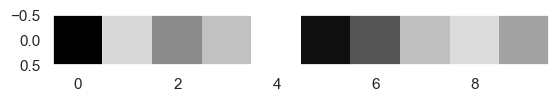

In [12]:
som_p1.plot_som()

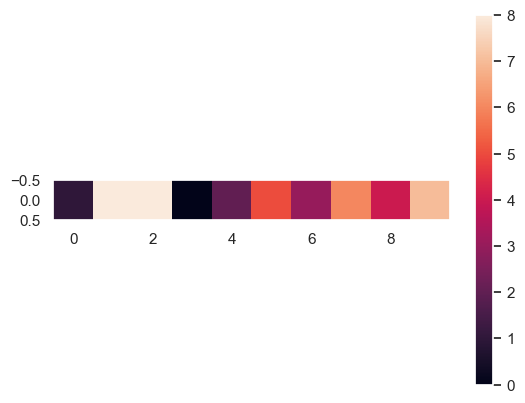

In [13]:
som_p1.plot_label_map()

In [14]:
som_p1.print_map_report()

Cluster:  (0, 0)
Number of samples in cluster:  8321
Number of samples per class:  [  30 4293    1   18    0    2    2    3   26 3946]
Most frequent class:  1
Frequency of class 0: 0.36%
Frequency of class 1: 51.59%
Frequency of class 2: 0.01%
Frequency of class 3: 0.22%
Frequency of class 4: 0.00%
Frequency of class 5: 0.02%
Frequency of class 6: 0.02%
Frequency of class 7: 0.04%
Frequency of class 8: 0.31%
Frequency of class 9: 47.42%
------------------------------------------------------------------
Cluster:  (0, 1)
Number of samples in cluster:  3021
Number of samples per class:  [460 619  13  33   7  12   8  78 920 871]
Most frequent class:  8
Frequency of class 0: 15.23%
Frequency of class 1: 20.49%
Frequency of class 2: 0.43%
Frequency of class 3: 1.09%
Frequency of class 4: 0.23%
Frequency of class 5: 0.40%
Frequency of class 6: 0.26%
Frequency of class 7: 2.58%
Frequency of class 8: 30.45%
Frequency of class 9: 28.83%
-----------------------------------------------------------

In [15]:
print(som_p1.evaluate(test_loader))

Evaluating:   0%|          | 0/10000 [00:00<?, ?it/s]

(0.4923, 0.4443738790181751)


#### Part 2

In [12]:
mask = np.ones((1, 10, 512))
nr = 3

train_loader = torch.utils.data.DataLoader(
    dataset=train_data, shuffle=True, batch_size=1
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, shuffle=False, batch_size=1
)


som_p2 = SOM(epochs=1, learning_rate=0.1, map_mask=mask, neighborhood_radius=nr)
som_p2.train(train_loader)

  0%|          | 0/50000 [00:00<?, ?batch/s]

Creating labels map:   0%|          | 0/50000 [00:00<?, ?it/s]

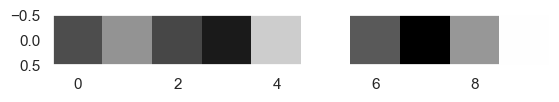

In [13]:
som_p2.plot_som()

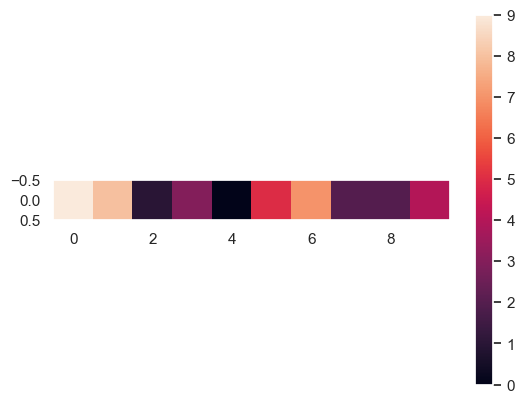

In [14]:
som_p2.plot_label_map()

In [15]:
som_p2.print_map_report()

Cluster:  (0, 0)
Number of samples in cluster:  11740
Number of samples per class:  [1097 4391   19   17    3    5    5   53 1731 4419]
Most frequent class:  9
Frequency of class 0: 9.34%
Frequency of class 1: 37.40%
Frequency of class 2: 0.16%
Frequency of class 3: 0.14%
Frequency of class 4: 0.03%
Frequency of class 5: 0.04%
Frequency of class 6: 0.04%
Frequency of class 7: 0.45%
Frequency of class 8: 14.74%
Frequency of class 9: 37.64%
------------------------------------------------------------------
Cluster:  (0, 1)
Number of samples in cluster:  5232
Number of samples per class:  [2048  210   55   31   23    8   52  100 2469  236]
Most frequent class:  8
Frequency of class 0: 39.14%
Frequency of class 1: 4.01%
Frequency of class 2: 1.05%
Frequency of class 3: 0.59%
Frequency of class 4: 0.44%
Frequency of class 5: 0.15%
Frequency of class 6: 0.99%
Frequency of class 7: 1.91%
Frequency of class 8: 47.19%
Frequency of class 9: 4.51%
-------------------------------------------------

In [16]:
print(som_p2.evaluate(test_loader))

Evaluating:   0%|          | 0/10000 [00:00<?, ?it/s]

(0.3629, 0.29313485909666753)
